[*********************100%***********************]  1 of 1 completed


Step: 11, Net Worth: 999.0, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 5.57757421875, Last Action: 1, Avg Buy Price: 0, Avg Sell Price: 0
Step: 12, Net Worth: 1001.7683238371936, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 0.1, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 0
Step: 13, Net Worth: 988.6514720538155, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 0.1, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 0
Step: 14, Net Worth: 959.0840003108632, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 8.0819453125, Last Action: 1, Avg Buy Price: 0, Avg Sell Price: 0
Step: 15, Net Worth: 908.1409643726961, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 11.2781640625, Last Action: 1, Avg Buy Price: 0, Avg Sell Price: 0
Step: 16, Net Worth: 903.1150968521486, Balance: 0.0, Crypto Held: 0.015938532348002507, Last Reward: 11.5934921875, Last Action: 1, Avg Buy Price: 0, Avg Sell Price: 0
Step: 17, Net Wort

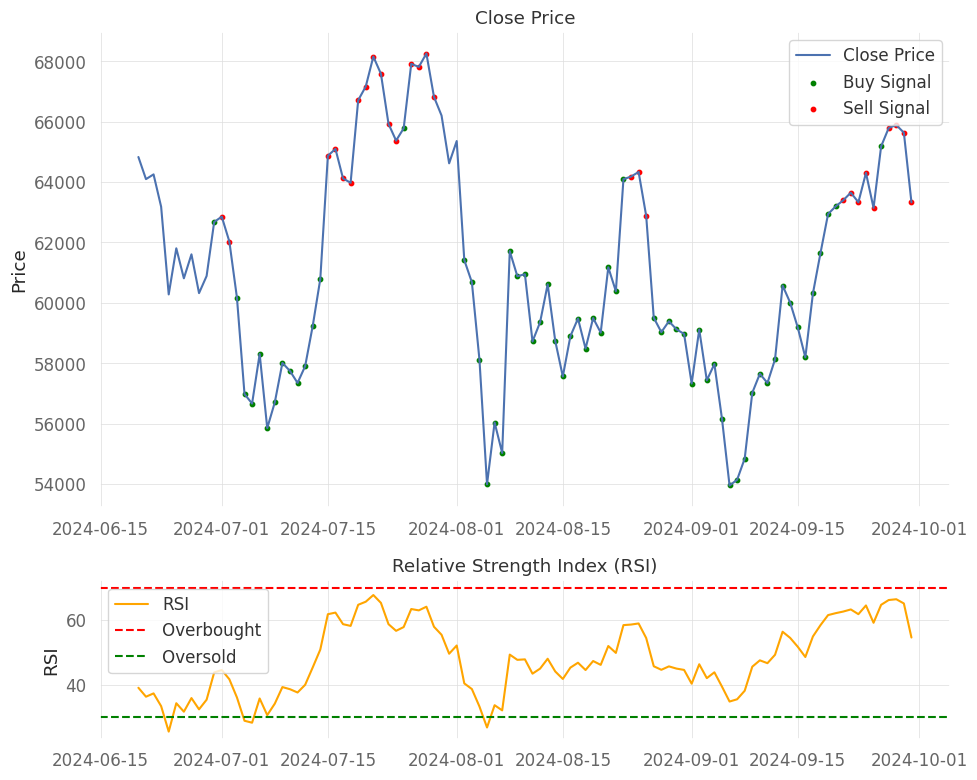

/tmp/ipykernel_145955/4250287230.py:103: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="H")  # Changed to hourly frequency


                    Strategy
------------------  ----------
Start Period        2024-06-20
End Period          2024-06-23
Risk-Free Rate      0.0%
Time in Market      99.0%

Cumulative Return   1.04%
CAGR﹪              138.27%

Sharpe              0.28
Prob. Sharpe Ratio  56.82%
Sortino             0.43
Sortino/√2          0.31
Omega               1.05

Max Drawdown        -20.96%
Longest DD Days     3

Gain/Pain Ratio     0.39
Gain/Pain (1M)      -

Payoff Ratio        1.01
Profit Factor       1.05
Common Sense Ratio  1.01
CPC Index           0.54
Tail Ratio          0.96
Outlier Win Ratio   3.49
Outlier Loss Ratio  2.94

MTD                 1.04%
3M                  1.04%
6M                  1.04%
YTD                 1.04%
1Y                  1.04%
3Y (ann.)           138.27%
5Y (ann.)           138.27%
10Y (ann.)          138.27%
All-time (ann.)     138.27%

Avg. Drawdown       -9.48%
Avg. Drawdown Days  2
Recovery Factor     0.22
Ulcer Index         0.11
Serenity Index      0.07


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


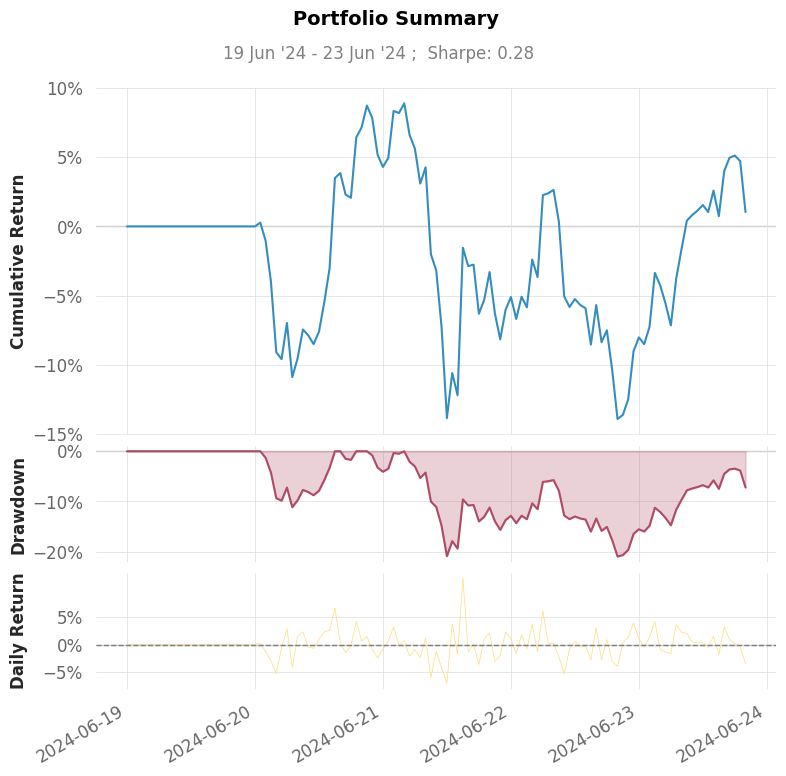

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


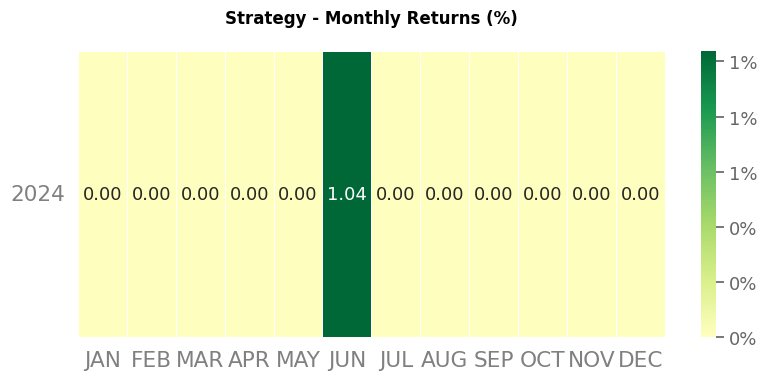

In [5]:

from ic.client import Client
from ic.identity import Identity
from ic.agent import Agent
from ic.candid import encode, Types
from meta.peaks_env import CryptoTradingEnv
from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators
import numpy as np
import pandas as pd
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import quantstats as qs
from utils.charts.plot_data_with_rsi import plot_data_with_rsi
from scipy.signal import find_peaks

# Constants
CANISTER_ID = "bkyz2-fmaaa-aaaaa-qaaaq-cai"
IC_URL = "http://127.0.0.1:4943"
OK_KEY = '_17724'
BUY_KEY = '_803992927'
HOLD_KEY = '_3308326'
SELL_KEY = '_925480882'

DECODE_DICT = {
    BUY_KEY: 0,
    HOLD_KEY: 1,
    SELL_KEY: 2
}


def decode_action(response):
    """Decode action from IC canister response"""
    result_variant = response[0]['value']
    if list(result_variant.keys())[0] != OK_KEY:
        raise ValueError("Invalid response")
    action_variant = DECODE_DICT[list(result_variant[OK_KEY].keys())[0]]
    return action_variant

def predict_ic(obs) -> int:
    """Get prediction from IC canister"""
    # Extract prices and portfolio from observation
    prices = obs['prices'].astype(np.float32).flatten().tolist()
    portfolio = obs['portfolio'].astype(np.float32).flatten().tolist()

    # Prepare parameters for canister call
    params = [
        {"type": Types.Vec(Types.Float32), "value": prices},
        {"type": Types.Vec(Types.Float32), "value": portfolio}
    ]
    
    # Setup IC client and make call
    client = Client(url=IC_URL)
    identity = Identity()
    agent = Agent(identity, client)
    
    response = agent.update_raw(CANISTER_ID, "get_action", encode(params))
    return decode_action(response)

# ====================================
# Model Evaluation
# ====================================

# Load test data
test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-10-01', '1d', ['RSI', 'EMA_50'])
test_data = test_data.copy()
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)
peaks, properties = find_peaks(test_data['Close'], height=100, prominence=5, distance=40)
test_data['Peak'] = 0
test_data.loc[test_data.index[peaks], 'Peak'] = 1
num_features = 5

# Setup environment
eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
obs = eval_env.reset()
# Run evaluation
portfolio_values = []

done = False

while not done:
    # Get prediction from IC canister
    action = predict_ic(obs)  # Use obs[0] since env is vectorized
    
    # Step through environment
    obs, rewards, done, info = eval_env.step([action])
    portfolio_values.append(info[0]['net_worth'])
    
    eval_env.render()
    
    if done[0]:
        actions_history = info[0]['actions_history']
        print('Episode done!')

eval_env.close()

# ====================================
# Portfolio Analysis
# ====================================

actions_history.index = pd.to_datetime(test_data.index)
plot_data_with_rsi(actions_history)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="H")  # Changed to hourly frequency
portfolio_series = pd.Series(portfolio_values, index=dates)
returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)